In [228]:
import glob

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import skeletonize
from skimage.morphology import convex_hull_image

from plantcv.plantcv.morphology import prune

from plantcv.plantcv import fill, fill_holes
import networkx as nx
import matplotlib.pyplot as plt
from sknw import build_sknw

In [229]:
#поиск в глубину 
def dfs(time, circle, src, visited,height,width):
    cx = int(circle[0]) # координата x центра вершины
    cy = int(circle[1]) # координата y центра вершины
    r = int(circle[2]) # радиус вершины
    todo = [(cy,cx)]
    degree = 0 # искомая степень вершины
    while todo:
        y,x = todo.pop() # берем координаты пикселя с вершины стека

        # ходим только по белым пикселям, которые лежат в пределах картинки и не были посещены ранее в этом же dfs
        if not (0 <= y < height) or not (0 <= x < width) or (src[y,x] == 0)  or (visited[y,x] == time):
            continue

        visited[y,x] = time # помечаем пиксель как посещенный 
        dist = (cx - x)**2 + (cy - y)**2
        if dist > 9 * r * r: # если мы удалились на расстояние в 3r от центра вершины, значит нашли новое ребро
            R = r
            cv.circle(visited, (x,y), int(R / 3), time, -1) # помечаем все пиксели в радиусе R как посещенные
            degree+=1 # увеличиваем степень вершины
            continue
        
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                ny = y + dy
                nx = x + dx
                todo += [(ny, nx)]
    #plt.imshow(visited + src)
    #plt.show()
    return degree


In [230]:
def get_description_graph(src, fname, idx):

    #---------------------НАХОЖДЕНИЕ ВЕРШИН ГРАФА И ПОДГОТОВКА ИЗОБРАЖЕНИЯ ДЛЯ ПОДСЧЕТА СТЕПЕНЕЙ ЭТИХ ВЕРШИН-----------------------------------------------------
    fig, axs = plt.subplots(2,3, figsize=(12, 7))
    fig.suptitle(fname)

    axs[0, 0].set_title('Original image')
    axs[0, 0].imshow(src[:,:,::-1])

    gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY) # переход к полутоновому изображению
   
    detected_circles = cv.medianBlur(gray, 5) # размытие для корректоного нахождения окружностей на рисунке (те вершин в графе)

    # нахождение окружностей на изображении (минимальное расстояние между окружностями == 75, минимальный радиус == 5, максимальный == 25)
    # все параметры подобранны опытным путем
    circles = cv.HoughCircles(detected_circles, cv.HOUGH_GRADIENT, 1.35, minDist=75,
                               param1=120, param2=35,
                               minRadius=5, maxRadius=25)
    
    tmp = cv.GaussianBlur(gray,(15,15), 0)
    tmp = cv.adaptiveThreshold(tmp, 255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,9,2)  
    tmp = (255 - tmp)
    
    axs[0, 1].imshow(tmp, cmap='gray')
    axs[0, 1].set_title('Mask')
    
    #plt.imshow(tmp, cmap='gray')
    #plt.show()
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
    tmp = cv.erode(tmp,  kernel, iterations=2)
    #plt.imshow(tmp, cmap='gray')
    #plt.show()
    r = int(np.min(circles[0, :][-1]))
    #лучше уменьшить как-то
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2 * r, 2* r))
    tmp = cv.morphologyEx(tmp, cv.MORPH_DILATE, kernel)
    #plt.imshow(tmp, cmap='gray')
    #plt.show()
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
    #tmp = cv.erode(tmp,  kernel, iterations=1)
    
    axs[0, 2].imshow(tmp, cmap='gray')
    axs[0, 2].set_title('Denoised mask')
    
    #plt.imshow(tmp, cmap='gray')
    #plt.show()
    tmp = skeletonize(np.clip(tmp, 0, 1)).astype(np.uint8)#get_skeleton(gray)
    #plt.imshow(tmp, cmap='gray')
    #plt.show()

    axs[1, 0].imshow(tmp, cmap='gray')
    axs[1, 0].set_title('Skeleton')

    tmp, segmented_img, segment_objects = prune(skel_img=tmp, size=int(75))

    axs[1, 1].imshow(tmp, cmap='gray')
    axs[1, 1].set_title('Pruned skeleton')
    #print(np.unique(tmp))
    if circles is not None:
       circles = np.uint16(np.around(circles))
    
       for i in circles[0, :]:
           cv.circle(tmp, (i[0],i[1]), 2 * i[2], 1, -1)
    
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------

    # создаем ядро для морфологических преобразований 
    #kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5));
    #tmp = cv.dilate(tmp,kernel, iterations = 1)


    #------------------------------------НАХОЖДЕИЕ СТЕПЕНЕЙ ВЕРШИН-----------------------------------------------------------------------------------------------
    visited = np.zeros(tmp.shape, np.uint8) # массив, где будем хранить посещенные вершины
    width,height = tmp.shape[1],tmp.shape[0] # ширина и высота изображения
    ans = np.zeros(10, np.uint8) # массив, в котором k-я компонента есть число вершин степени k в представленном графе

    # если нашли вершины, то
    if circles is not None:
       circles = np.uint16(np.around(circles))
       time = 1;# текущее "время". Нужно, чтобы мы не могли ходить по одним и тем же пикселям в вызове одного dfs'а, но могли ходить по одним и тем же пикселям в разных dfs'ах

       #идем по всем врешинам, считаем их степени в dfs
       for i in circles[0, :]:
           # начинаем поиск в глубину от центра вершины. Функция возвращает степень текущей вершины
           cnt = dfs(time, i, tmp,visited, height, width)
           ans[cnt]+=1 # обновляем ответ
           time += 1 # обновляем "время"
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------
    axs[1, 2].imshow(tmp + visited)
    axs[1, 2].set_title('Degree detecting')
    plt.savefig(f'images_results/{idx}.jpg')
    plt.show()
    return ans

In [231]:
import re
i = 1

In [232]:
re.sub(r'open_[a-zA-Z0-9]*/[a-zA-Z0-9]*/', '', 'open_cv/Intermediate/2.jpg')

'2.jpg'

In [233]:
!ls

__pycache__              sknw.py                  task2_intermediate.ipynb
images                   task2.ipynb
images_results           task2_expert.ipynb


processing of image 2.jpg


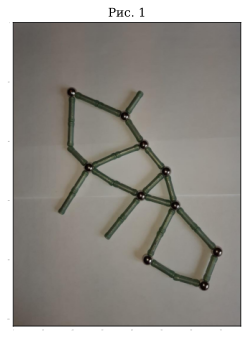

processing of image 3.jpg


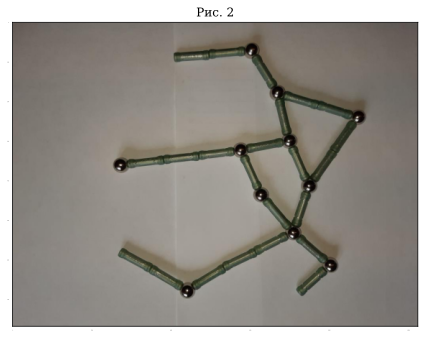

processing of image 9.jpg


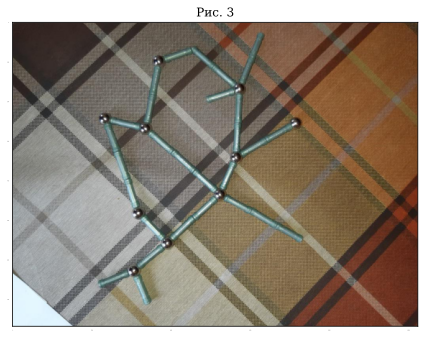

processing of image 22.jpg


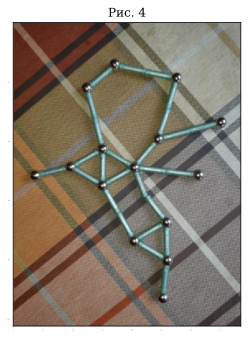

In [235]:
arr = glob.glob('images/Intermediate/*.jpg')
arr += glob.glob('images/Expert/*.jpg')
graph_class = {'[0 0 4 3 3 0 0 0 0 0]': [], 
                '[0 1 5 4 1 0 0 0 0 0]': [], 
                '[0 4 3 5 2 1 0 0 0 0]': [], 
                '[0 1 3 4 2 0 0 0 0 0]': []} # словарь для классов графа
etalons = ['2.jpg', '3.jpg', '22.jpg', '9.jpg']
j=1
for el in arr:
    fname = re.sub(r'[a-zA-Z0-9]*/[a-zA-Z0-9]*/', '', el)
    if fname in etalons:
        print('processing of image ' + fname)
        src = cv.imread(el)
        plt.title(f'Рис. {j}')
        
        plt.imshow(src[:,:,::-1])
        plt.savefig(f'images/{j}.jpg', bbox_inches='tight')
        j += 1
        i += 1
        plt.show()

13.jpg
processing of image images/Intermediate/13.jpg
20


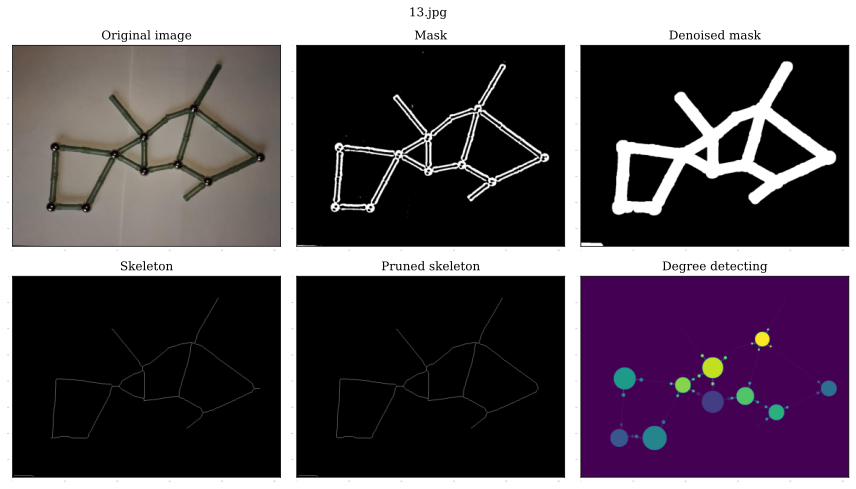


ANSWER:
CLASS 1: ['images/Intermediate/13.jpg']
CLASS 2: []
CLASS 3: []
CLASS 4: []
25.jpg
processing of image images/Intermediate/25.jpg
21


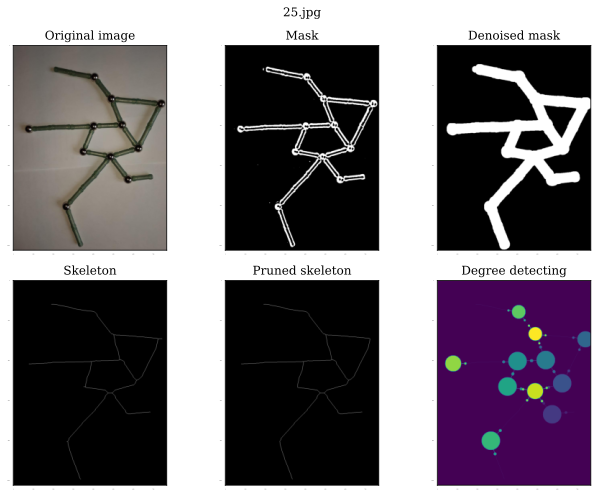


ANSWER:
CLASS 1: ['images/Intermediate/13.jpg']
CLASS 2: ['images/Intermediate/25.jpg']
CLASS 3: []
CLASS 4: []
19.jpg
processing of image images/Intermediate/19.jpg
22


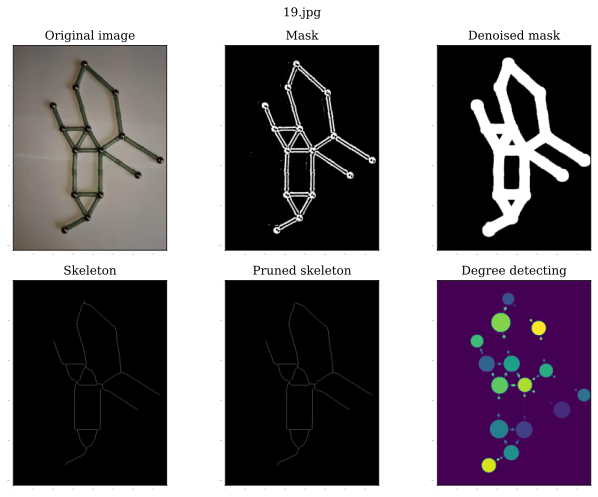


ANSWER:
CLASS 1: ['images/Intermediate/13.jpg']
CLASS 2: ['images/Intermediate/25.jpg']
CLASS 3: ['images/Intermediate/19.jpg']
CLASS 4: []
4.jpg
processing of image images/Intermediate/4.jpg
23


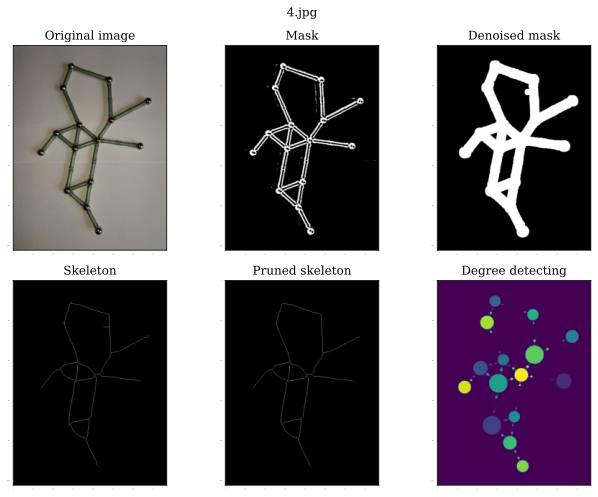


ANSWER:
CLASS 1: ['images/Intermediate/13.jpg']
CLASS 2: ['images/Intermediate/25.jpg']
CLASS 3: ['images/Intermediate/19.jpg', 'images/Intermediate/4.jpg']
CLASS 4: []
5.jpg
processing of image images/Intermediate/5.jpg
24


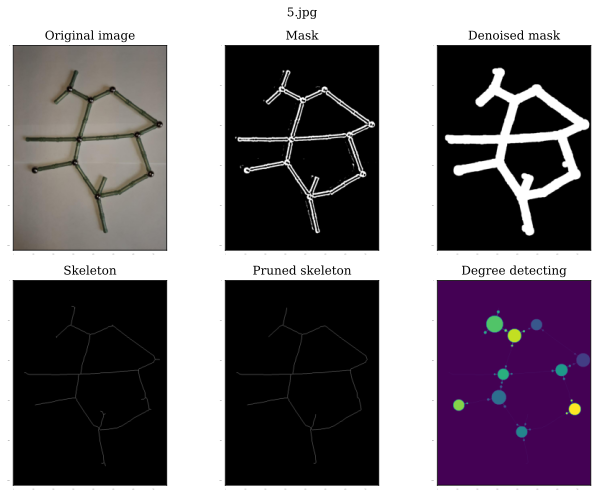


ANSWER:
CLASS 1: ['images/Intermediate/13.jpg']
CLASS 2: ['images/Intermediate/25.jpg']
CLASS 3: ['images/Intermediate/19.jpg', 'images/Intermediate/4.jpg']
CLASS 4: ['images/Intermediate/5.jpg']
7.jpg
processing of image images/Intermediate/7.jpg
25


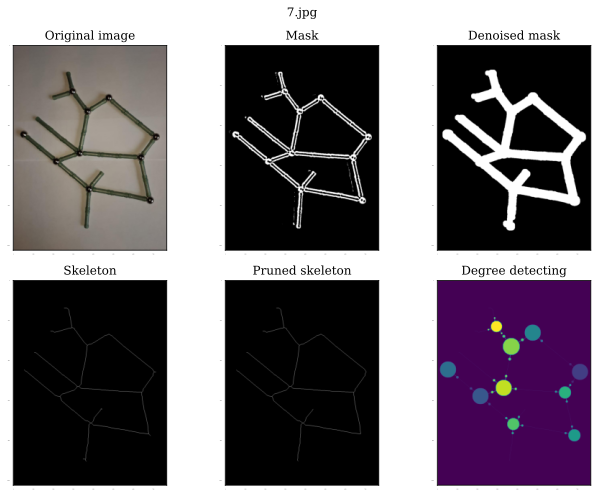


ANSWER:
CLASS 1: ['images/Intermediate/13.jpg']
CLASS 2: ['images/Intermediate/25.jpg']
CLASS 3: ['images/Intermediate/19.jpg', 'images/Intermediate/4.jpg']
CLASS 4: ['images/Intermediate/5.jpg', 'images/Intermediate/7.jpg']
2.jpg
processing of image images/Intermediate/2.jpg
26


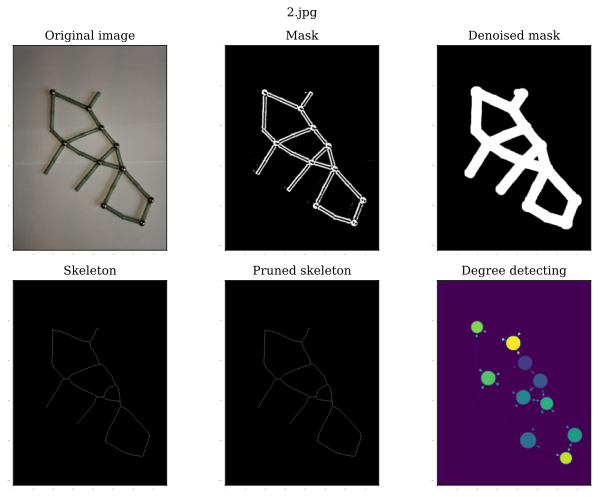


ANSWER:
CLASS 1: ['images/Intermediate/13.jpg', 'images/Intermediate/2.jpg']
CLASS 2: ['images/Intermediate/25.jpg']
CLASS 3: ['images/Intermediate/19.jpg', 'images/Intermediate/4.jpg']
CLASS 4: ['images/Intermediate/5.jpg', 'images/Intermediate/7.jpg']
3.jpg
processing of image images/Intermediate/3.jpg
27


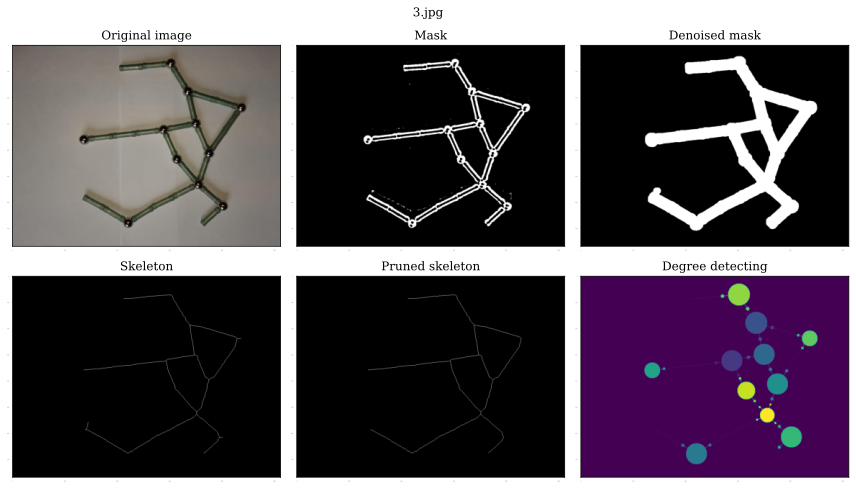


ANSWER:
CLASS 1: ['images/Intermediate/13.jpg', 'images/Intermediate/2.jpg']
CLASS 2: ['images/Intermediate/25.jpg', 'images/Intermediate/3.jpg']
CLASS 3: ['images/Intermediate/19.jpg', 'images/Intermediate/4.jpg']
CLASS 4: ['images/Intermediate/5.jpg', 'images/Intermediate/7.jpg']


In [226]:
arr = glob.glob('images/Intermediate/*.jpg')
graph_class = {'[0 0 4 3 3 0 0 0 0 0]': [], 
                '[0 1 5 4 1 0 0 0 0 0]': [], 
                '[0 4 3 5 2 1 0 0 0 0]': [], 
                '[0 1 3 4 2 0 0 0 0 0]': []} # словарь для классов графа

for i, el in enumerate(arr, 20):
    etalons = ['2.jpg', '3.jpg', '22.jpg', '9.jpg']
    fname = re.sub(r'[a-zA-Z0-9]*/[a-zA-Z0-9]*/', '', el)
    print(fname)
    if fname in etalons or True:
        print('processing of image ' + el)
        print(i)
        src = cv.imread(el) # считываем изображение
        ans = get_description_graph(src, fname, i) # находим массив со всеми степенями вершин
        ans_str = str(ans) # для использования массива как ключа в словаре, переводим его в сторку
        if ans_str not in graph_class:
            graph_class[ans_str] = list() # создаем новый список под новый класс
        graph_class[ans_str].append(el) # добавляем граф в нужный класс


        # вывод ответа
        print('\nANSWER:')
        num_class = 0
        for el in graph_class.values():
            num_class +=1
            print("CLASS", str(num_class) + ":", el)


In [150]:
from pykuwahara import kuwahara

In [151]:
def detect_shape(src):
    img_gr = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    _, img_gr = cv.threshold(img_gr,255,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    img_gr= cv.GaussianBlur(img_gr, (3,3), 80)
    img_gr = cv.medianBlur(img_gr, 3, 20)
    contours, heirarchy = cv.findContours(img_gr, cv.RETR_EXTERNAL, 
        cv.CHAIN_APPROX_NONE)
    for c in contours:
        shape = 0
        other = 0
        peri = cv.arcLength(c, True)
        approx = cv.approxPolyDP(c, 0.04 * peri, True)
        #print(len(approx))
        if len(approx)  >= 3:
            shape +=1
            M = cv.moments(c)
            cX = int(M["m10"] / (M["m00"] + 0.001))
            cY = int(M["m01"] / (M["m00"] + 0.001))
            cv.circle(src, (cX,cY), 20, 255, -1)
            

        else:
            other += 1
    plt.imshow(src)
    plt.show()
    return

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import pywt

from skimage import (
    data, restoration, util
)
from plantcv import plantcv as pcv
def plot_result(image, mask):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

    ax[0].imshow(image[:,:,::-1])
    ax[0].set_title('Original image')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    ax[2].imshow(image * mask[:,:, None], cmap='gray')
    ax[2].set_title('Result')
    ax[2].axis('off')

    fig.tight_layout()

In [128]:
def get_circles(src):
    

IndentationError: expected an indented block (894936032.py, line 2)

In [129]:
if __name__ == "__main__":
    print('START')

    arr = glob.glob('open_cv/Intermediate/*.jpg');
    for el in arr:
        print('processing of image ' + el)

        src = cv.imread(el) # считываем изображение
        get_circles(src)
    

START
processing of image open_cv/Intermediate/13.jpg


NameError: name 'get_circles' is not defined

In [153]:
#поиск в глубину 
def dfs2(time, circle, src, visited,height,width):
    cx = int(circle[0]) # координата x центра вершины
    cy = int(circle[1]) # координата y центра вершины
    todo = [(cy,cx)]
    degree = 0 # искомая степень вершины
    while todo:
        y,x = todo.pop() # берем координаты пикселя с вершины стека

        # ходим только по белым пикселям, которые лежат в пределах картинки и не были посещены ранее в этом же dfs
        if not (0 <= y < height) or not (0 <= x < width) or (src[y,x] == 0)  or (visited[y,x] == time):
            continue

        visited[y,x] = time # помечаем пиксель как посещенный 
        dist = ((cx - x)**2 + (cy - y)**2) ** 0.5
        if dist > 55:
            R = 5
            cv.circle(visited, (x,y), R, time, -1) # помечаем все пиксели в радиусе R как посещенные
            degree+=1 # увеличиваем степень вершины
            continue
        
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                ny = y + dy
                nx = x + dx
                todo += [(ny, nx)]
    
    return degree

In [154]:
from sklearn.metrics.pairwise import euclidean_distances
def merge_equal_points(points, min_dist=100):
    pdist = euclidean_distances(points)
    merged_points_mask = np.zeros(len(pdist), dtype=bool)
    for i in range(len(pdist)):
        #print(pdist[i])
        if merged_points_mask[i]: continue
        #print(min_dist)
        merged_points_mask |= ((pdist[i] <= min_dist) & (pdist[i] != 0.0))
        #print(merged_points_mask)
    #print(points[~merged_points_mask])
    return points[~merged_points_mask]

In [188]:
plt.rc('axes', grid=False)
plt.rc('xtick', labelsize=0)
plt.rc('xtick.major', size=0)
plt.rc('xtick.minor', size=0)
plt.rc('ytick', labelsize=0)
plt.rc('ytick.major', size=0)
plt.rc('ytick.minor', size=0)
plt.rc('figure', autolayout=True)
plt.rc('font', family='serif')


In [189]:
re.sub(r'[a-zA-Z0-9]*/[a-zA-Z0-9]*/', '', 'images/Expert/10.jpg')

'10.jpg'

processing of image images/Expert/9.jpg


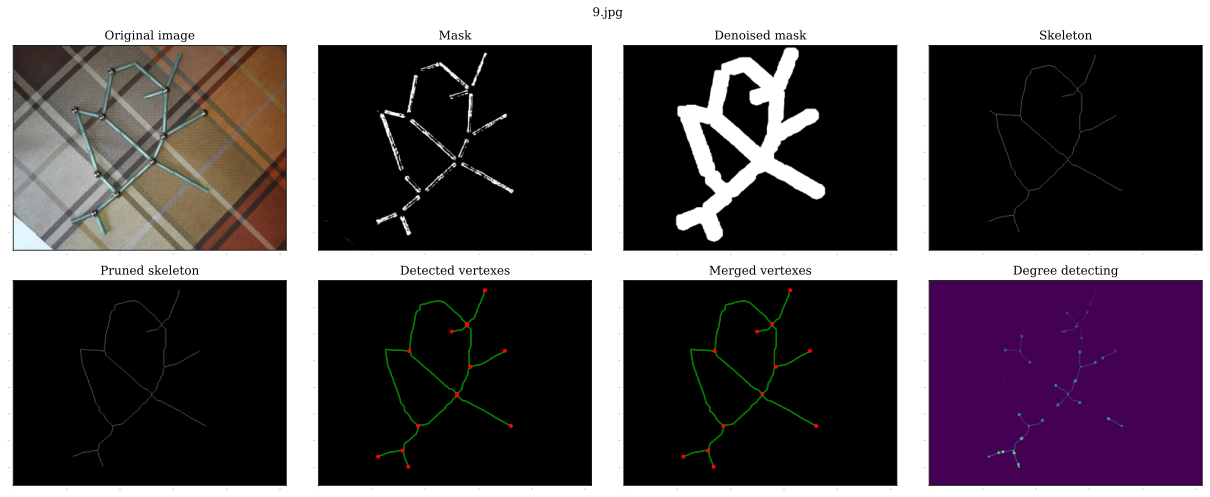

processing of image images/Expert/28.jpg


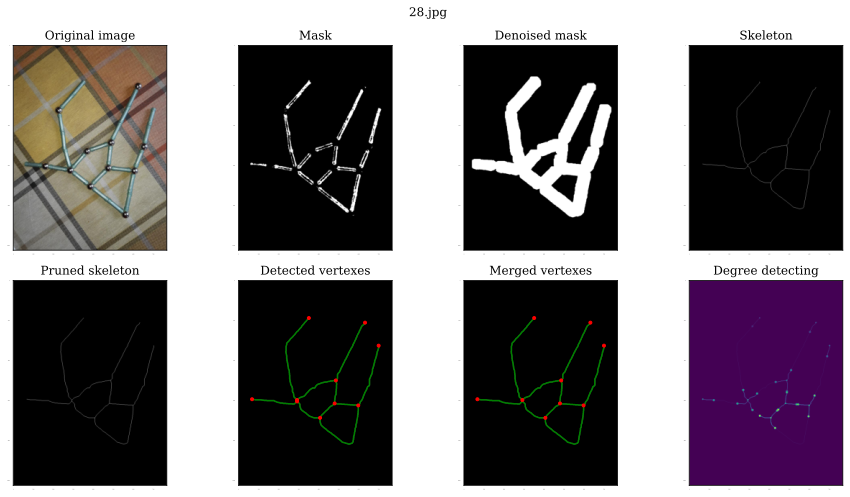

processing of image images/Expert/29.jpg


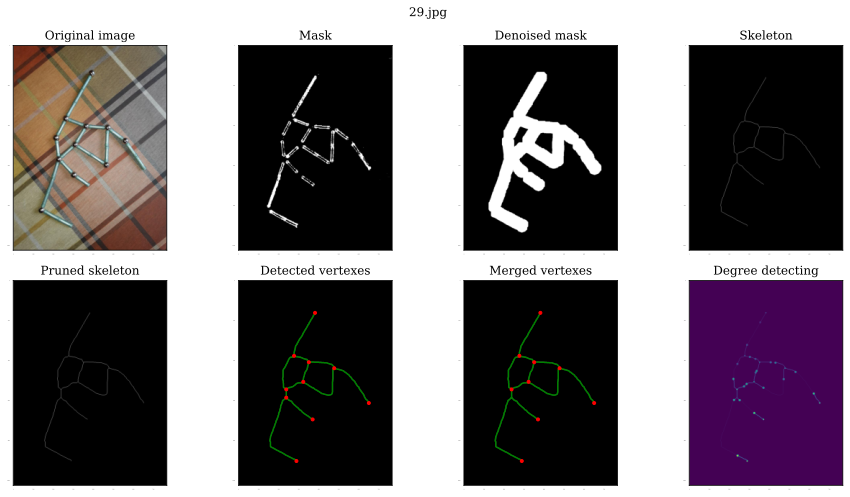

processing of image images/Expert/16.jpg


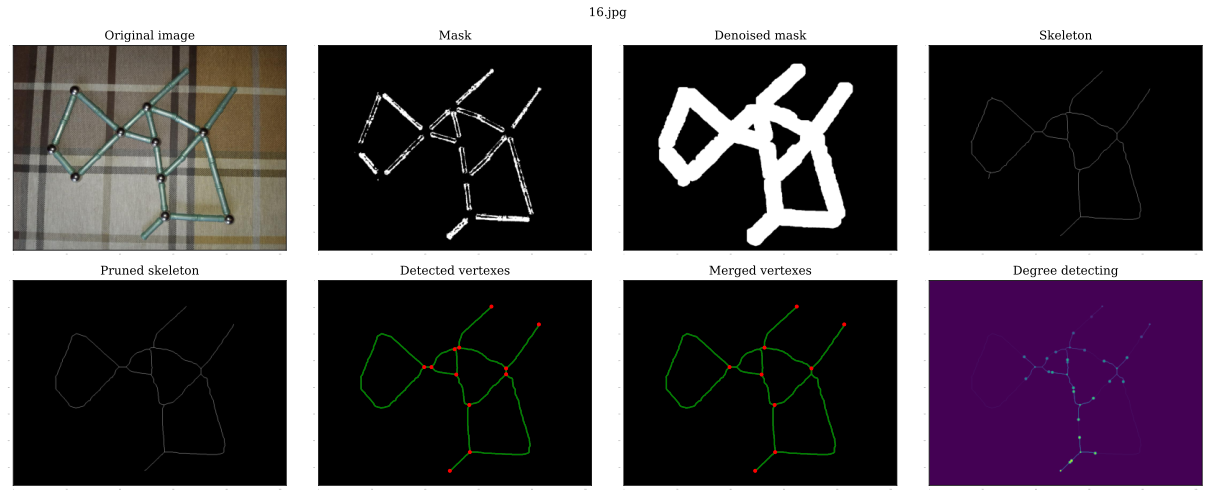

processing of image images/Expert/10.jpg


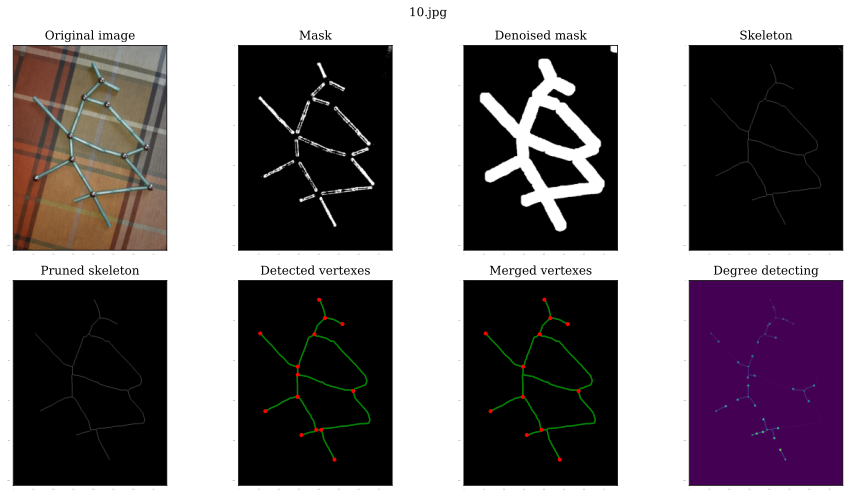

processing of image images/Expert/22.jpg


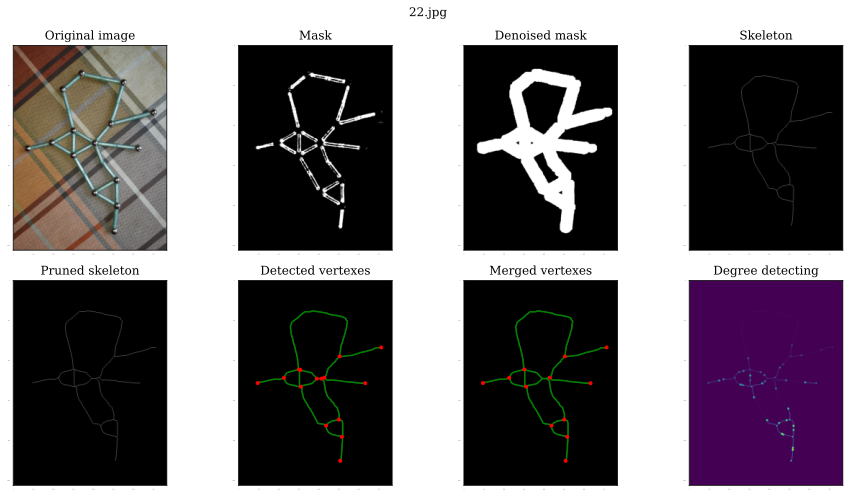

processing of image images/Expert/23.jpg


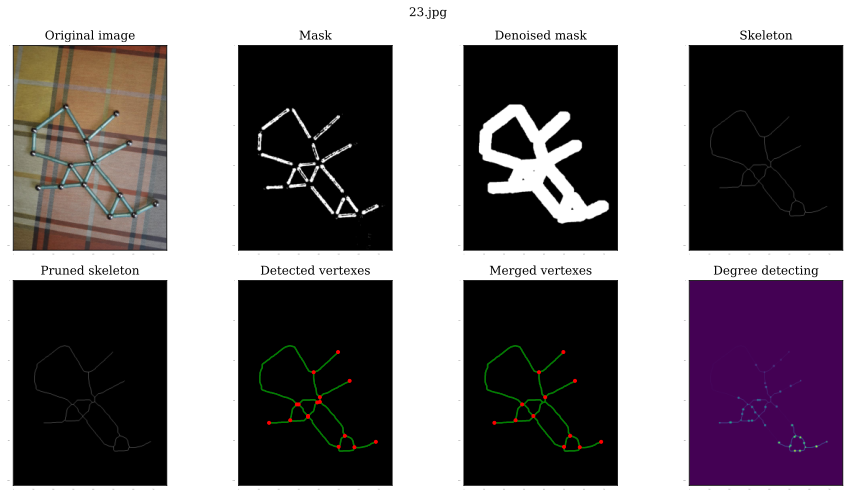

processing of image images/Expert/18.jpg


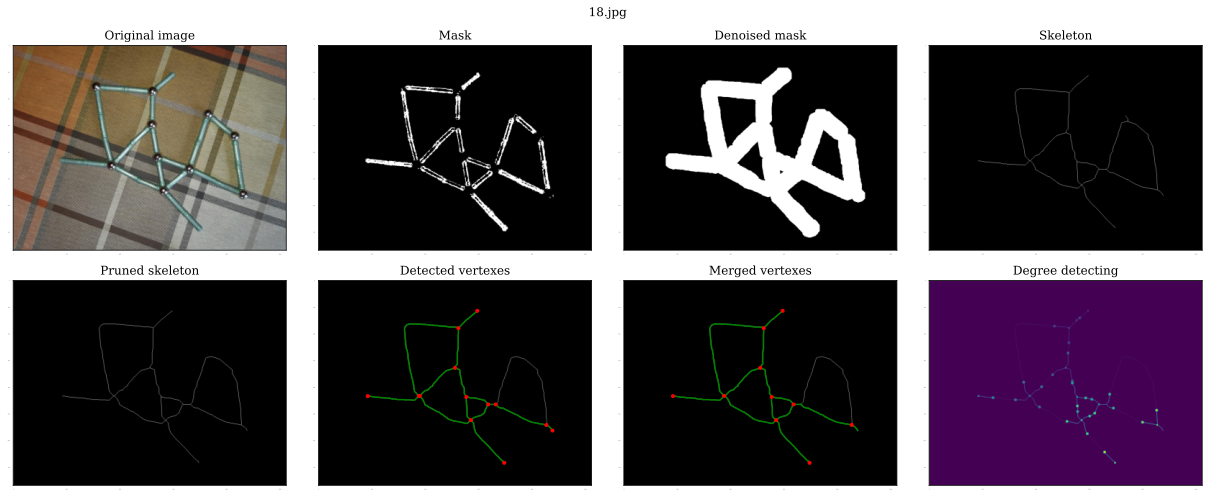

In [202]:
arr = glob.glob('images/Expert/*.jpg');

for idx, el in enumerate(arr):
    #etalons = ['2.jpg', '3.jpg', '22.jpg', '9.jpg']
    fname = re.sub(r'[a-zA-Z0-9]*/[a-zA-Z0-9]*/', '', el)
    if fname in etalons or True:
        fig, axs = plt.subplots(2,4, figsize=(18, 7))
        fig.suptitle(fname)
        print('processing of image ' + el)

        src = cv.imread(el) # считываем изображение
        gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY) # переход к полутоновому изображению
        hsv = cv.cvtColor(src, cv.COLOR_BGR2HSV)

        axs[0, 0].set_title('Original image')
        axs[0, 0].imshow(src[:,:,::-1])

        lower_blue = np.array([ 70, 45, 94])
        upper_blue = np.array([120, 200, 255])
        mask = cv.inRange(hsv, lower_blue, upper_blue)


        mask = np.clip(mask, 0, 1).astype(np.uint8)

        axs[0, 1].imshow(mask, cmap='gray')
        axs[0, 1].set_title('Mask')
        #plt.show()
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
        tmp = cv.erode(mask,  kernel, iterations=1)
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (10,10))
        tmp = cv.dilate(tmp,  kernel, iterations=5)
        
        axs[0, 2].imshow(tmp, cmap='gray')
        axs[0, 2].set_title('Denoised mask')
        #plt.show()
        tmp = skeletonize(np.clip(tmp, 0, 1)).astype(np.uint8)
        axs[0, 3].imshow(tmp, cmap='gray')
        axs[0, 3].set_title('Skeleton')
        tmp, segmented_img, segment_objects = prune(skel_img=tmp, size=int(110))
        axs[1, 0].imshow(tmp, cmap='gray')
        axs[1, 0].set_title('Pruned skeleton')
        #plt.show()
        
        g = build_sknw(tmp, ring=False, iso=False)

        #axs[4].imshow(gray, cmap='gray')
        #plt.show()
        
        # draw image
        axs[1, 1].imshow(tmp, cmap='gray')

        # draw edges by pts
        for (s,e) in g.edges():
            ps = g[s][e]['pts']
            axs[1, 1].plot(ps[:,1], ps[:,0], 'green')
            
        # draw node by o
        nodes = g.nodes()
        #print(nodes[0])
        ps = np.array([nodes[i]['o'] for i in nodes])
        axs[1, 1].plot(ps[:,1], ps[:,0], 'r.')
        axs[1, 1].set_title('Detected vertexes')

        #plt.show()
        
        circles = np.array([nodes[i]['o'] for i in nodes])
        
        circles[:, [0, 1]] = circles[:, [1, 0]]
        #print('circles', circles)
        #print('ps', ps)
        circles = merge_equal_points(circles, min_dist=45)
        # draw image
        axs[1, 2].imshow(tmp, cmap='gray')
        for (s,e) in g.edges():
            ps = g[s][e]['pts']
            axs[1, 2].plot(ps[:,1], ps[:,0], 'green')
            
        # draw node by o
        
        axs[1, 2].plot(circles[:,0], circles[:,1], 'r.')
        axs[1, 2].set_title('Merged vertexes')

        # title and show
        #plt.show()
        if circles is not None:
            circles = np.uint16(np.around(circles))
        
        for i in circles:
            cv.circle(tmp, (i[0],i[1]), 3, 1, -1)
        visited = np.zeros(tmp.shape, np.uint8) # массив, где будем хранить посещенные вершины
        width,height = tmp.shape[1], tmp.shape[0] # ширина и высота изображения
        ans = np.zeros(10, np.uint8) # массив, в котором k-я компонента есть число вершин степени k в представленном графе
        if circles is not None:
            circles = np.uint16(np.around(circles))
            time = 1;# текущее "время". Нужно, чтобы мы не могли ходить по одним и тем же пикселям в вызове одного dfs'а, но могли ходить по одним и тем же пикселям в разных dfs'ах

            #идем по всем врешинам, считаем их степени в dfs
            for i in circles:
                    # начинаем поиск в глубину от центра вершины. Функция возвращает степень текущей вершины
                    cnt = dfs2(time, i, tmp, visited, height, width)
                    ans[cnt]+=1 # обновляем ответ
                    time += 1 # обновляем "время
            axs[1, 3].imshow(visited + tmp)
            axs[1, 3].set_title('Degree detecting')
        plt.tight_layout()
        plt.savefig(f'images_results/{idx}.jpg', bbox_inches='tight')
        #fig.tight_layout(True)
        plt.show()